# 03a - Creating Predictions on Test Set

The notebook contains pipeline for testing CNN model.

In [1]:
%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
import numpy as np
import pandas as pd

import torch
from fastai.vision.all import (ToTensor, Normalize, Resize,
                               Learner, CSVLogger, SaveModelCallback)

from src.core import models, metrics, data
from src.utils import nb_setup, io
from src.dev import experiments as exp


DATA_DIR = 'data/snake_clef2021_dataset/'
TRAIN_SET_DIR = 'train'
TEST_SET_DIR = 'test'

SEED = 42

nb_setup.init()
nb_setup.set_random_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


## Get Training Configuration (network architecture, loss, optimizer, ...)

In [3]:
OUTPUT_DIR = 'output/'
SPECS_PATH = 'training_history/submission_runs/'
RUN_ID, SPECS_FILE = 1, SPECS_PATH + 'clef2021_resnest200_ce_05-11-2021_13-24.json'
# RUN_ID, SPECS_FILE = 2, SPECS_PATH + 'clef2021_resnest200_ce_05-15-2021_08-42.json'
# RUN_ID, SPECS_FILE = 3, SPECS_PATH + 'clef2021_resnet101_ce_04-24-2021_14-07.json'
# RUN_ID, SPECS_FILE = 4, SPECS_PATH + 'clef2021_resnext101_ce_04-29-2021_07-36.json'
# runs 5 and 6 are ensemble models computed in notebook 03b
# RUN_ID, SPECS_FILE = 7, SPECS_PATH + 'clef2021_resnest101_ce_05-10-2021_15-32.json'

config = exp.Config(DATA_DIR + SPECS_FILE)
_model_config = models.get_model_config(config.model)
config['model_mean'] = _model_config['mean']
config['model_std'] = _model_config['std']
config.save(DATA_DIR + SPECS_FILE)
print(config)

Config(
* model_file: clef2021_resnest200_ce_05-11-2021_13-24.pth
* history_file: clef2021_resnest200_ce_05-11-2021_13-24.csv
* no_epochs: 60
* model: resnest200
* loss: ce
* opt: sgd
* input_size: 320
* batch_size: 64
* full_ds: True
* aug: False
* scheduler: False
* learning_rate: 0.1
* model_mean: (0.485, 0.456, 0.406)
* model_std: (0.229, 0.224, 0.225))


## Load the Data

In [4]:
# load metadata
train_df = pd.read_csv(DATA_DIR + 'SnakeCLEF2021_train_metadata_PROD.csv')

# remove flickr images as they are not validated
train_df = train_df[train_df['source'] != 'flickr']
train_df = data.get_valid_col(train_df, ['binomial', 'country'], 'valid', valid_pct=0.1)

test_df = pd.read_csv(DATA_DIR + 'SnakeCLEF2021_TEST_METADATA.csv')

no_classes = len(train_df['binomial'].drop_duplicates())
print('No classes:', no_classes)

No classes: 768


In [5]:
species = np.unique(train_df['binomial'])
countries = np.unique(train_df['country'])

# load country-species map, country-country LuT and rename countries
country_map_df = pd.read_csv(DATA_DIR + 'species_to_country_mapping.csv', index_col=0)
country_country_lut = (pd.read_csv(DATA_DIR + 'country_lut.csv')
                       .drop_duplicates('b').set_index('b')['a'].to_dict())
_country_map_df = country_map_df.rename(columns=country_country_lut)

# create country weight matrix
country_weights = metrics.clean_country_map(country_map_df, species, missing_val=0)
country_weights = torch.Tensor(country_weights.values).to(device)

# create country weight matrix with only species and countries available in dls
country_weights_adj = metrics.clean_country_map(
    _country_map_df, species, countries, missing_val=1)
country_weights_adj = torch.Tensor(country_weights_adj.values).to(device)

In [6]:
def remove_missing_country(df, ref_df):
    df = df.copy()
    cond = (df['country'].isnull() | ~df['country'].isin(ref_df['country'].drop_duplicates()))
    print('Found missing countries:', cond.sum())
    df.loc[cond, 'country'] = 'unknown'
    return df


train_df[train_df['valid']] = remove_missing_country(
    train_df[train_df['valid']], train_df[~train_df['valid']])
test_df = remove_missing_country(test_df, train_df[~train_df['valid']])

Found missing countries: 0
Found missing countries: 919


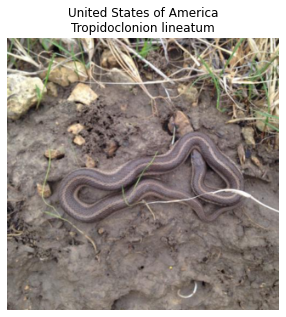

In [7]:
# define transforms
item_tfms = [ToTensor, Resize(config.input_size)]
batch_tfms = Normalize.from_stats(config.model_mean, config.model_std)

# create image data loaders
train_df['_image_path'] = TRAIN_SET_DIR + train_df['image_path']
dls, dblock = data.create_country_dls(
    train_df, path=DATA_DIR,
    fn_col='_image_path', country_col='country',
    label_col='binomial', valid_col='valid',
    bs=config.batch_size, item_tfms=item_tfms, batch_tfms=batch_tfms,
    num_workers=4, device=device)

dls.show_batch(max_n=1)

### Create Test Set DataLoader

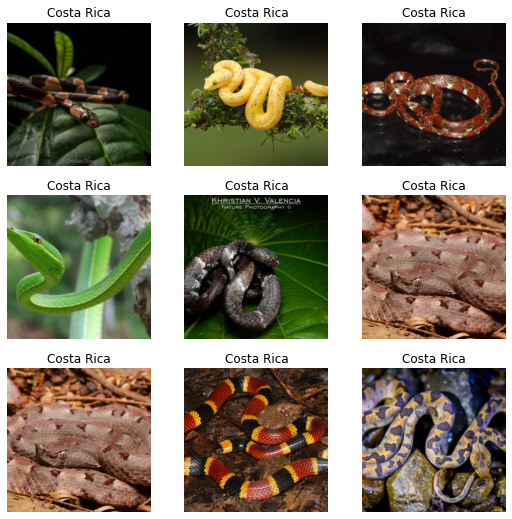

In [8]:
# include testset into dls
test_df['_image_path'] = TEST_SET_DIR + '/' + test_df['file_path']
test_dl = dls.test_dl(test_df)

test_dl.show_batch(max_n=9)

## Create fastai Learner

In [ ]:
# no_classes = 772

In [9]:
from src.core import country_pipeline

learner = Learner(
    dls,
    model=country_pipeline.create_model(config.model, no_classes, pretrained=False),
    loss_func=country_pipeline.CrossEntropyLoss(country_weights_adj),
    metrics=country_pipeline.wrap_metrics([
        metrics.pytorch.accuracy,
        metrics.pytorch.F1Score(),
        metrics.pytorch.CountryF1Score(country_weights)], country_weights_adj))
learner.load(config.model_file.replace('.pth', ''))

/home/chamirai/.local/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [ ]:
# from fastai.vision.all import Callback


# class TmpCallback(Callback):
#     def after_pred(self):
#         pred, country = self.learn.pred
#         if pred.shape[1] == 772:
#             remove_ids = [77, 246, 452, 493]
#             use_ids = [i for i in range(772) if i not in remove_ids]
#             pred = pred[:, use_ids]
#         self.learn.pred = (pred, country)


# learner.add_cb(TmpCallback)

## Evaluate Metrics on Validation Set

In [10]:
# create predictions
val_preds, val_targs = learner.get_preds(dl=dls.valid)
assert np.allclose(val_preds.sum(1), 1)

# save file
filename = OUTPUT_DIR + f'val_preds_{RUN_ID}.pt'
torch.save((val_preds, val_targs), filename)
print(f'Saved to: {filename}')

Saved to: output/val_preds_1.pt


In [11]:
# evaluate results
out = learner.validate(dl=dls.valid)
pd.Series(out, index=['valid_loss', 'accuracy', 'f1_score', 'country_f1_score'])

valid_loss          1.140468
accuracy            0.790340
f1_score            0.636531
country_f1_score    0.697103
dtype: float64

## Compute Predictions on Test Set

In [12]:
test_idx = test_dl.get_idxs()

# create predictions
test_preds, _ = learner.get_preds(dl=test_dl)
assert np.allclose(test_preds.sum(1), 1)

# save file
filename = OUTPUT_DIR + f'test_preds_{RUN_ID}.pt'
torch.save(test_preds, filename)
print(f'Saved to: {filename}')

Saved to: output/test_preds_1.pt


In [13]:
test_preds_np = test_preds.argmax(1).cpu().numpy()


# map test preds on class ids
vocab = np.array(dls.vocab[1])
test_preds_names = pd.Series(vocab[test_preds_np])

class_id_map = (train_df[['binomial', 'class_id']].drop_duplicates()
                .set_index('binomial')['class_id'].to_dict())
test_preds_id = test_preds_names.replace(class_id_map)


# create prediction dataframe
out_df = pd.DataFrame(test_df['UUID'][test_idx])
assert len(out_df) == len(test_preds_id)
out_df['prediction'] = test_preds_id
out_df

,UUID,prediction
0,f8e1d62d-8c74-47ae-8db9-c4fb0d7a5672,338
1,3068da5b-a72c-4398-8f70-afb2134cfa8d,83
2,fcaece2a-90c7-4b07-80cf-f901e188dea8,635
3,7aa20f9f-2f55-4f8f-93a2-a5a229df4232,509
4,a2743578-8204-4f4d-b8e9-1ee65bad4925,637
...,...,...
23668,5bd061ad-00fe-4c54-ad56-317db73410ba,51
23669,8d7a534a-a5fe-40da-aafa-a06805e267c2,184
23670,6dc610be-05f9-461c-bc59-9ff8ce174423,699
23671,975abfa9-f351-46f7-b1c9-825b819e533a,152


In [14]:
# save to csv
filename = OUTPUT_DIR + f'SnakeCLEF2021_submission_{RUN_ID}.csv'
out_df.to_csv(filename, sep=',', index=False)
print(f'Saved to: {filename}')

Saved to: output/SnakeCLEF2021_submission_1.csv
